In [1]:
import pandas as pd

In [2]:
# Deactivate logging for visibility reasons
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [20]:
# Read the datasets
df_inverters = None
for i in ["1", "2", "3", "1-lodz", "2-lodz", "3-lodz"]:
    inverter_data = pd.read_json(f"data/carbon-intensity/inverter{i}.json")
    inverter_data.columns = ["date", f"inverter{i}"]
    if df_inverters is None:
        df_inverters = inverter_data
    else:
        df_inverters = df_inverters.merge(inverter_data, left_on="date", right_on="date")
df_inverters = df_inverters.set_index("date")

# remove unexpected low values
df_inverters = df_inverters.applymap(lambda x: 0 if x<50 else x)

# combine datasets with carbon emissions and energy mix
carbon_emissions = pd.read_json("data/carbon-intensity/energy-mix.json")
carbon_intensity = pd.DataFrame({
    "date": pd.to_datetime(carbon_emissions["pv"].apply(lambda x: x["index"])), 
    "pv": carbon_emissions["pv"].apply(lambda x: x["pred"]),
    "wind": carbon_emissions["wind"].apply(lambda x: x["pred"]),
    "total": carbon_emissions["total"].apply(lambda x: x["pred"])
})

# Recompute carbon intensity for Poland
carbon_intensity["brown"] = carbon_intensity["total"] - carbon_intensity["pv"] - carbon_intensity["wind"]
carbon_intensity["carbon_intensity"] = (1139*0.8*carbon_intensity["brown"] + 529*0.2*carbon_intensity["brown"]+35*carbon_intensity["pv"]+13*carbon_intensity["wind"])/carbon_intensity["total"]
carbon_intensity = carbon_intensity.set_index("date")

# Combine carbon intensity with inverters
emissions_df = df_inverters.merge(carbon_intensity, left_index=True, right_index=True)
emissions_df = emissions_df.reset_index()

# Compute the seconds of running for the simulation
emissions_df["seconds"] = emissions_df.index * 60*60
emissions_df["prediction"] = emissions_df[["inverter1", "inverter2", "inverter3", "inverter1-lodz", "inverter2-lodz", "inverter3-lodz"]].mean(axis=1)

# Sort to low-level emission periods for the scheduling
ordered_emissions = emissions_df.sort_values(['prediction', 'carbon_intensity'], ascending=[False, True])

In [4]:
from simulation import * 
# import code of simulation functions

In [5]:
import random

trials = ["50rounds_tensorflow-cifar10", "50rounds_pytorch-cifar10", "50rounds_pytorch-mnist", "50rounds_tensorflow-mnist"]

nodes = ["compute005", "compute006", "compute010", 
         "compute012", "compute013", "compute016", 
         "compute022", "compute025", "compute030", 
         "compute035"]

nodes = [f"aeros1-{i}" for i in nodes]

trial_for_predictions = dict()


for trial in trials:
    
    # use data from executed trials to model the utilization needs and power consumption
    df = pd.read_csv(f"{trial}.csv")
    td = pd.to_datetime(df.tail(1).timestamp.reset_index().timestamp) - pd.to_datetime(df.head(1).timestamp.reset_index().timestamp)
    duration = td.loc[0].seconds

    node_profiles = dict()
    for i, node in enumerate(nodes):
        node_df = df[df["hostname"] == node]
        node_profiles[i] = dict(
            node_cpu_need = node_df.currentCpuUsage.quantile(0.99),
            node_memory_need = node_df.currentRamUsage.quantile(0.99),
            node_power_need = node_df.currentPowerConsumption.mean(),
            node_energy_need = node_df.currentPowerConsumption.mean()*duration
        )
    trial_for_predictions[trial] = dict(
        node_profiles = node_profiles,
        duration = duration,
        rounds = int(trial.split("rounds")[0])
    )


In [6]:
from datetime import datetime

# Generalize the results of the runs to other Federated Learning configurations
class WorkloadPredictor(object):
    trial_for_predictions = trial_for_predictions

    def get_fl_deployment(self, backend="tensorflow", dataset="cifar10", number_of_rounds=50, number_of_clients=9, start_at = None, tolerance=None):
        nodes = []
        
        self.duration = number_of_rounds * self.trial_for_predictions[f"50rounds_{backend}-{dataset}"]["duration"]/self.trial_for_predictions[f"50rounds_{backend}-{dataset}"]["rounds"]
        
        fl_id = int(datetime.now().timestamp())
        nodes.append(self.get_server_node(f"server_{fl_id}", backend, dataset, number_of_rounds))
        for i in range(number_of_clients):
            nodes.append(self.get_client_node(f"client_{i}_{fl_id}", backend, dataset, number_of_rounds))
        return Service(f"{backend}-{dataset}-{number_of_rounds}-{number_of_clients}-{fl_id}", nodes, start_at, tolerance)
        
        
    
    def get_client_node(self, id, backend="tensorflow", dataset="cifar10", number_of_rounds=50):
        i=random.randint(1,9)
        node_profile = self.trial_for_predictions[f"50rounds_{backend}-{dataset}"]["node_profiles"][i]
        return Task(
            task_id = id,
            cpu = node_profile["node_cpu_need"],
            memory = node_profile["node_memory_need"],
            duration = self.duration,
            power = node_profile["node_power_need"]
            # node_energy_need = number_of_rounds * node_profile["node_energy_need"]/50
        )

    def get_server_node(self, id, backend="tensorflow", dataset="cifar10", number_of_rounds=50):
        node_profile = self.trial_for_predictions[f"50rounds_{backend}-{dataset}"]["node_profiles"][0]
        return Task(
            task_id = id,
            cpu = node_profile["node_cpu_need"],
            memory = node_profile["node_memory_need"],
            duration = self.duration,
            power = node_profile["node_power_need"]
            # node_energy_need = number_of_rounds * node_profile["node_energy_need"]/50
        )


In [7]:
# creation of the simulation configurations

computed_intensity = []
for tolerance in [0, 3, 6, 9, 12]:
    backends = ["tensorflow", "pytorch"]
    datasets = ["mnist", "cifar10"]
    rounds = [50, 100, 200, 400]
    tolerances = [tolerance]
    
    number_of_configurations = 15
    random.seed(5)
    
    workloads = []
    for i in range(number_of_configurations):
    
        deployment = WorkloadPredictor().get_fl_deployment(
            backend=random.choice(backends), 
            dataset=random.choice(datasets), 
            number_of_clients=9, 
            number_of_rounds=random.choice(rounds),
            start_at=0, #random.randint(0, 2*24*60*60),
            tolerance=random.choice(tolerances) 
        )
        
        workloads.append(deployment)
        
    nodes= [ComputeNode(node_id=f"compute_node_{i}", total_cpu=100, total_memory=257809) for i in range(37)]
    output = pd.DataFrame(schedule_services(workloads, nodes, simulation_time=2*24*60*60, ordered_emissions=ordered_emissions))

    output["hour"] = (output.time/(60*60)).astype(int)
    grouped_per_hour = output.groupby("hour")["power"].sum()/(60*60)
    overall_dataset = pd.DataFrame(grouped_per_hour).merge(emissions_df, left_index=True, right_index=True)
    
    overall_dataset = overall_dataset.set_index("date")

    for i in ["1", "2", "3", "2-lodz", "3-lodz", "1-lodz"]:
        
        # compute carbon intensity for each configuration
        overall_dataset["energy_need"] = (overall_dataset["power"] - overall_dataset[f"inverter{i}"]).apply(lambda x: 0 if x<0 else x)
        overall_dataset["workload_carbon_intensity"] = (overall_dataset["carbon_intensity"]*(overall_dataset["energy_need"]/1000))
        overall_dataset["workload_carbon_intensity_without_RES"] = (overall_dataset["carbon_intensity"]*(overall_dataset["power"]/1000))
        computed_intensity.append({
            "Configuration": 0 if tolerance == 0 else f"Random Start - {tolerance}h Tolerance",
            "RES": i,
            "Carbon Emission with RES": overall_dataset["workload_carbon_intensity"].sum(),
            "Carbon Emission without RES": overall_dataset["workload_carbon_intensity_without_RES"].sum()
        })

100%|█████████████████████████████████| 172800/172800 [00:54<00:00, 3157.78it/s]


Text(0.5, 0, 'Date')

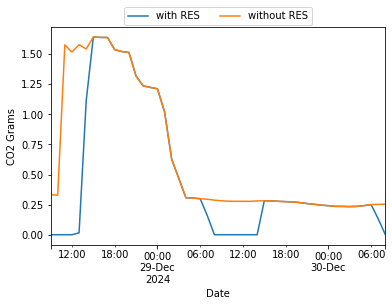

In [11]:
# Plot the last configuration ("1-lodz") of the previous for-loop
import matplotlib.pyplot as plt 
(overall_dataset[["workload_carbon_intensity", "workload_carbon_intensity_without_RES"]]/1000).rename(columns={"workload_carbon_intensity": "with RES", "workload_carbon_intensity_without_RES": "without RES"}).plot()
plt.legend(bbox_to_anchor=(.5, 1.051), loc="center", ncol=2)
plt.ylabel("CO2 Grams")
plt.xlabel("Date")

In [12]:
overall_dataset["workload_carbon_intensity_without_RES"] = (overall_dataset["carbon_intensity"]*(overall_dataset["power"]/1000))


In [13]:
import matplotlib.pyplot as plt
# Create the overall carbon intensity for each configuration
carbon_df = pd.DataFrame(computed_intensity)
carbon_df["Configuration"] = carbon_df["Configuration"].str.replace(" - ", "\n")
carbon_df["Configuration"] = carbon_df["Configuration"].fillna("Optimal\nDuration")
carbon_df["Carbon Emission with RES"] /= 1000 # in kilograms
carbon_df["Carbon Emission without RES"] /= 1000 # in kilograms

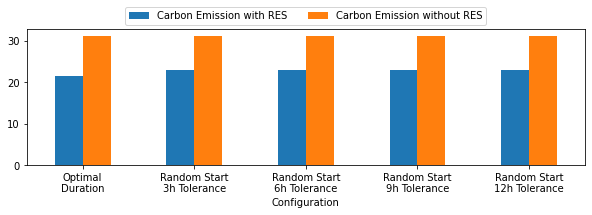

In [14]:


# carbon["Configuration"] = carbon["Configuration"].str.replace("Optimal Duration", "Optimal\nDuration")

carbon_df[carbon_df["RES"]=="1-lodz"][["Carbon Emission with RES", "Carbon Emission without RES", "Configuration"]].plot.bar(x="Configuration", rot=0, figsize=(10,2.5))
plt.legend(bbox_to_anchor=(.5, 1.1), loc="center", ncol=2)

In [15]:
df_temp_carb = carbon_df[carbon_df["RES"]=="1-lodz"][["Carbon Emission with RES", "Carbon Emission without RES", "Configuration"]]

In [16]:
(df_temp_carb[["Carbon Emission with RES"]]-df_temp_carb["Carbon Emission with RES"].max())/df_temp_carb["Carbon Emission with RES"].max()

,Carbon Emission with RES
5,-0.062154
11,0.000000
17,0.000000
23,0.000000
29,0.000000


Text(0.5, 0, 'RES & Location')

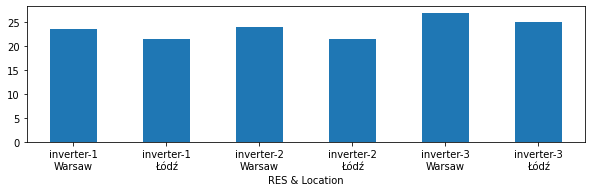

In [17]:

ax = carbon_df[carbon_df["Configuration"]=="Optimal\nDuration"][["Carbon Emission with RES", "RES"]].sort_values("RES").plot.bar(
    x="RES", rot=0, figsize=(10,2.5), legend=False)
ax.set_xticklabels(["inverter-1\nWarsaw","inverter-1\nŁódź","inverter-2\nWarsaw","inverter-2\nŁódź","inverter-3\nWarsaw","inverter-3\nŁódź"], rotation=0)
ax.set_xlabel("RES & Location")


In [18]:
carbon_df[carbon_df["Configuration"]=="Optimal\nDuration"]

,Configuration,RES,Carbon Emission with RES,Carbon Emission without RES
0,Optimal\nDuration,1,23.723633,31.26464
1,Optimal\nDuration,2,24.012133,31.26464
2,Optimal\nDuration,3,27.024012,31.26464
3,Optimal\nDuration,2-lodz,21.644672,31.26464
4,Optimal\nDuration,3-lodz,25.144330,31.26464
5,Optimal\nDuration,1-lodz,21.591350,31.26464
